<a href="https://colab.research.google.com/github/bdstel/Machine-Learning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Username: bradensteller

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, GridSearchCV, train_test_split

In [ ]:
train_data = pd.read_csv("/content/train.csv").drop(columns = ['id'])
test_data = pd.read_csv("/content/test.csv").drop(columns = ['id'])

In [ ]:
train_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.5,0.40,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0,0
1,11.5,0.18,0.51,4.0,0.104,4.0,23.0,0.99960,3.28,0.97,10.1,1
2,8.2,0.34,0.37,1.9,0.057,43.0,74.0,0.99408,3.23,0.81,12.0,1
3,10.7,0.43,0.39,2.2,0.106,8.0,32.0,0.99860,2.89,0.50,9.6,0
4,7.6,0.42,0.25,3.9,0.104,28.0,90.0,0.99784,3.15,0.57,9.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
794,6.6,0.96,0.00,1.8,0.082,5.0,16.0,0.99360,3.50,0.44,11.9,1
795,7.5,0.58,0.56,3.1,0.153,5.0,14.0,0.99476,3.21,1.03,11.6,1
796,5.6,0.31,0.78,13.9,0.074,23.0,92.0,0.99677,3.39,0.48,10.5,1
797,8.4,0.62,0.12,1.8,0.072,38.0,46.0,0.99504,3.38,0.89,11.8,1


---
# Missing Values

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         799 non-null    float64
 1   volatile acidity      799 non-null    float64
 2   citric acid           799 non-null    float64
 3   residual sugar        799 non-null    float64
 4   chlorides             799 non-null    float64
 5   free sulfur dioxide   799 non-null    float64
 6   total sulfur dioxide  799 non-null    float64
 7   density               799 non-null    float64
 8   pH                    799 non-null    float64
 9   sulphates             799 non-null    float64
 10  alcohol               799 non-null    float64
 11  quality               799 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 75.0 KB


As shown above, each column has 799 non-null values, meaning that there were no missing values found within the entire data set.

# Outliers

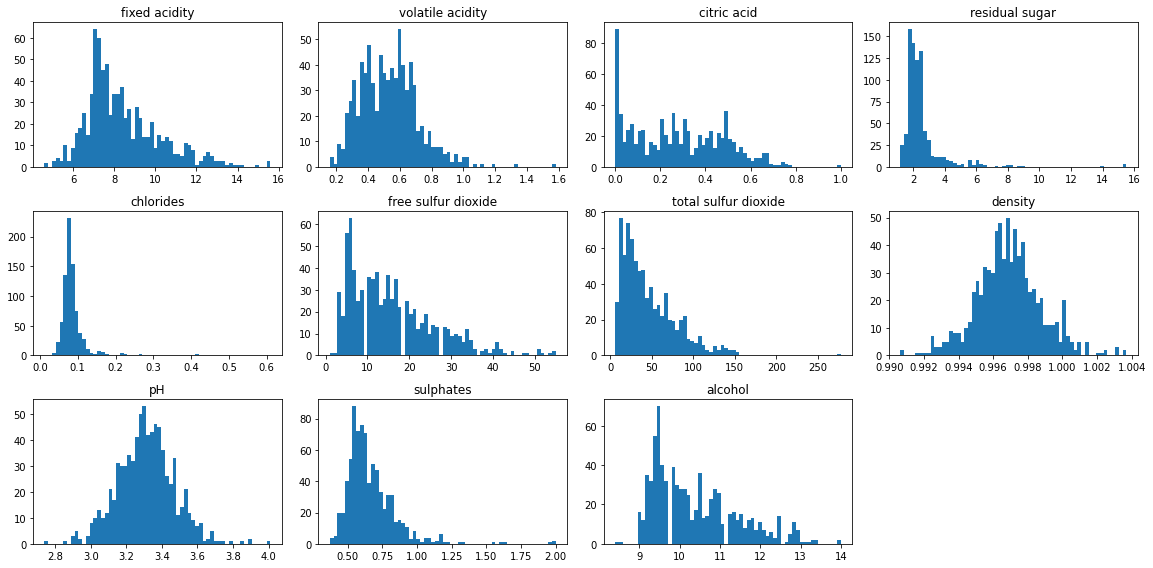

In [ ]:
train_data.iloc[:, :-1].hist(bins = 60, figsize = (16, 8), grid = False, layout = (3, 4))
plt.tight_layout()
plt.show()

As shown by the histogram plots, much of the data appears to be right-skewed, aside from density and pH which appear to have a normal distribution. This shows that there are a few outliers within the dataset that are really high compared to the rest of the data.

In order to keep the effect of these outliers to a minimum, I will clamp the values.

# Data Preprocessing

In [ ]:
for column in train_data.iloc[:, :-1]:
  q1 = np.percentile(train_data.loc[:, column], 25, interpolation = 'midpoint')
  q3 = np.percentile(train_data.loc[:, column], 75, interpolation = 'midpoint')
  iqr = q3 - q1
  upper = q3 + (iqr * 1.5)
  lower = q1 - (iqr * 1.5)
  for index, value in enumerate(train_data.loc[:, column]):
    if value > upper:
      train_data.loc[index, column] = upper
    elif value < lower:
      train_data.loc[index, column] = lower

Now that the outliers have been clamped, we'll take another look at the histogram plots.

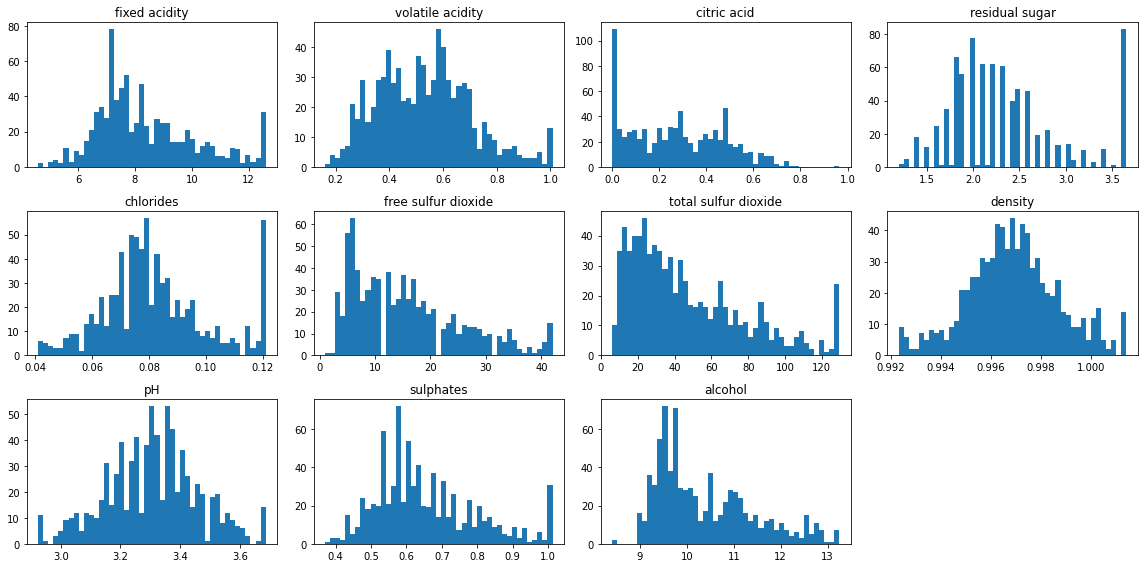

In [ ]:
train_data.iloc[:, :-1].hist(bins = 45, figsize = (16, 8), grid = False, layout = (3, 4))
plt.tight_layout()
plt.show()

And just to be sure that clamping didn't affect anything other than the values of the outliers:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         799 non-null    float64
 1   volatile acidity      799 non-null    float64
 2   citric acid           799 non-null    float64
 3   residual sugar        799 non-null    float64
 4   chlorides             799 non-null    float64
 5   free sulfur dioxide   799 non-null    float64
 6   total sulfur dioxide  799 non-null    float64
 7   density               799 non-null    float64
 8   pH                    799 non-null    float64
 9   sulphates             799 non-null    float64
 10  alcohol               799 non-null    float64
 11  quality               799 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 75.0 KB


In order to determine whether I will normalize the data, we need to see whether it will have a positive effect on the outcome. I'll set up a baseline model and use it for the current data and the normalized data to see this difference.

In [ ]:
def base_model(data):
  X = data.drop(columns = ['quality'])
  y = data['quality']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

  neighbors = KNeighborsClassifier()
  neighbors.fit(X_train, y_train)

  predict_prob = neighbors.predict_proba(X_test)[:, 1]
  predict = neighbors.predict(X_test)

  print("ROC AUC Score:", roc_auc_score(y_test, predict_prob))
  print("F1 Score:", f1_score(y_test, predict))
  print("Accuracy Score:", accuracy_score(y_test, predict))

First: Using the model on the current set of data

In [ ]:
base_model(train_data)

ROC AUC Score: 0.6860198624904508
F1 Score: 0.6719999999999999
Accuracy Score: 0.6583333333333333


Now we will test this same model using a normalized version of the data

In [ ]:
col_max = train_data.max()
train_data_max = col_max.max()
normalized_data = train_data / train_data_max
normalized_data['quality'] = train_data['quality']

normalized_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.065637,0.003089,0.003089,0.028185,0.000386,0.023166,0.077220,0.007688,0.025328,0.004324,0.092664,0
1,0.088803,0.001390,0.003938,0.028185,0.000803,0.030888,0.177606,0.007719,0.025328,0.007490,0.077992,1
2,0.063320,0.002625,0.002857,0.014672,0.000440,0.324324,0.571429,0.007676,0.024942,0.006255,0.092664,1
3,0.082625,0.003320,0.003012,0.016988,0.000819,0.061776,0.247104,0.007711,0.022587,0.003861,0.074131,0
4,0.058687,0.003243,0.001931,0.028185,0.000803,0.216216,0.694981,0.007705,0.024324,0.004402,0.070270,0
...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.050965,0.007413,0.000000,0.013900,0.000633,0.038610,0.123552,0.007673,0.027027,0.003398,0.091892,1
795,0.057915,0.004479,0.004324,0.023938,0.000934,0.038610,0.108108,0.007682,0.024788,0.007819,0.089575,1
796,0.043243,0.002394,0.006023,0.028185,0.000571,0.177606,0.710425,0.007697,0.026178,0.003707,0.081081,1
797,0.064865,0.004788,0.000927,0.013900,0.000556,0.293436,0.355212,0.007684,0.026100,0.006873,0.091120,1


In [ ]:
base_model(normalized_data)

ROC AUC Score: 0.6942186088527552
F1 Score: 0.6751054852320675
Accuracy Score: 0.6791666666666667


Between both base model functions, the F1 score appeared to improve some of the time when using normalized data over the current data, however the effect appeared to be minimal if at all. Because of this, I will not implement normalization as it does not seem to be necessary.

# Model Training

In [ ]:
X = train_data.drop(columns = ['quality'])
y = train_data['quality']

In [ ]:
def random_search_hyperparam():
  parameters = dict(n_neighbors = np.arange(1, 100),
                    weights = ['uniform', 'distance'],
                    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    p = np.arange(1, 10),
                    metric = ['minkowski', 'manhattan', 'euclidean'])

  neighbors_cv = RandomizedSearchCV(KNeighborsClassifier(), param_distributions = parameters, cv = 5, n_jobs = -1, scoring = 'f1', n_iter = 100)
  neighbors_cv.fit(X, y)

  print('Parameters: ', neighbors_cv.best_params_)
  print('F1 Score: ', neighbors_cv.best_score_)

random_search_hyperparam()

Parameters:  {'weights': 'distance', 'p': 6, 'n_neighbors': 87, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
F1 Score:  0.7386562386980672


Running the Randomized Search a few times gave me a decent idea of which parameters were better to use than others, which helped me narrow my parameter ranges for the following grid search in order to cut down on runtime.

In [ ]:
def grid_search_hyperparam():
  parameters = dict(n_neighbors = np.arange(70, 90),
                    weights = ['distance'],
                    algorithm = ['ball_tree', 'kd_tree', 'brute'],
                    p = np.arange(1, 10),
                    metric = ['minkowski', 'manhattan'])

  neighbors_cv = GridSearchCV(KNeighborsClassifier(), param_grid = parameters, scoring = 'f1', n_jobs = -1, cv = 5, verbose = 1)
  neighbors_cv.fit(X, y)

  print('Parameters: ', neighbors_cv.best_params_)
  print('F1 Score: ', neighbors_cv.best_score_)

grid_search_hyperparam()

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4548 tasks      | elapsed:  2.7min


Parameters:  {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 82, 'p': 1, 'weights': 'distance'}
F1 Score:  0.7456519246508946


[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  2.8min finished


The Grid Search shows that these are the parameters that gave me the highest F1 Score, thus I will use those parameters when training the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

neighbors = KNeighborsClassifier(n_neighbors = 82,
                                 weights = 'distance',
                                 algorithm = 'ball_tree',
                                 p = 1)
neighbors.fit(X_train, y_train)

predict_prob = neighbors.predict_proba(X_test)[:, 1]
predict = neighbors.predict(X_test)

print("ROC AUC Score:", roc_auc_score(y_test, predict_prob))
print("F1 Score:", f1_score(y_test, predict))
print("Accuracy Score:", accuracy_score(y_test, predict))

ROC AUC Score: 0.8221958705357144
F1 Score: 0.7803030303030303
Accuracy Score: 0.7583333333333333


From the training of the model above, these were the highest scores I was able to obtain:

ROC AUC: 0.8466629118558153

F1: 0.8013937282229965

Accuracy: 0.7625

# Final Prediction

In [ ]:
final_test_X = test_data

X = train_data.drop(columns = ['quality'])
y = train_data['quality']

neighbors.fit(X, y)
predictions = neighbors.predict(final_test_X)

output = pd.DataFrame({'id': np.arange(0, 800), 'quality': predictions})
output = output.set_index('id')
print(output)
output.to_csv('my_submission.csv')

     quality
id          
0          0
1          0
2          0
3          1
4          1
..       ...
795        0
796        1
797        0
798        1
799        1

[800 rows x 1 columns]
